In [1]:
# Import required libraries
import pandas as pd
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import math
from scipy import stats
from scipy.stats import normaltest, jarque_bera, skew, kurtosis

In [2]:
# Load and examine the dataset
df = pd.read_csv('bookings_train.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
df.info()
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (203693, 11)

First 5 rows:
                                 booking_id  citizen_id booking_date  \
0  f7b59ba3793fea61282cb02be2247cebd0a75306  4229044420   2021-01-01   
1  cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80  5389442635   2021-01-01   
2  0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8  2123783919   2021-01-01   
3  d4bf826153212fa325ad98b215668ab942365607  6359918966   2021-01-01   
4  ebb4c9687acbaf65376d8e379bd1341d1c15127e   178732202   2021-01-01   

  appointment_date appointment_time        check_in_time  \
0       2021-01-01            09:03  2021-01-01 09:11:00   
1       2021-01-01            09:12  2021-01-01 09:24:00   
2       2021-01-01            09:36  2021-01-01 09:29:00   
3       2021-01-01            09:45  2021-01-01 10:07:00   
4       2021-01-01            10:12  2021-01-01 10:26:00   

                  check_out_time   task_id  num_documents  queue_number  \
0  2021-01-01 09:48:15.166353269  TASK-002              0             2   
1  2021-01-01

In [3]:
# Descriptive statistics
print("Descriptive statistics:")
print(df.describe())

Descriptive statistics:
         citizen_id  num_documents   queue_number  satisfaction_rating
count  2.036930e+05  203693.000000  203693.000000        203693.000000
mean   4.996145e+09       2.436790       9.310511             4.187277
std    2.880985e+09       1.734511       8.245711             0.463539
min    4.318100e+04       0.000000       1.000000             3.000000
25%    2.504323e+09       1.000000       3.000000             4.000000
50%    4.995536e+09       2.000000       7.000000             4.000000
75%    7.491514e+09       3.000000      13.000000             4.000000
max    9.999975e+09      14.000000     133.000000             5.000000


In [ ]:
# Parse date and time columns
print("1. Parsing datetime columns...")
df['booking_date'] = pd.to_datetime(df['booking_date'], errors='coerce')
df['appointment_date'] = pd.to_datetime(df['appointment_date'], errors='coerce')

# Parse appointment time and create appointment datetime
df['appointment_time_parsed'] = pd.to_datetime(df['appointment_time'], format='%H:%M', errors='coerce').dt.time
df['appointment_datetime'] = pd.to_datetime(
    df['appointment_date'].dt.strftime('%Y-%m-%d') + ' ' + df['appointment_time_parsed'].astype(str),
    errors='coerce'
)

# Parse check-in/out timestamps
df['check_in_time'] = pd.to_datetime(df['check_in_time'], errors='coerce')
df['check_out_time'] = pd.to_datetime(df['check_out_time'], errors='coerce')

# Calculate target variable: processing time in minutes
print("2. Calculating target variable...")
df['processing_time_minutes'] = (df['check_out_time'] - df['check_in_time']).dt.total_seconds() / 60.0

# Filter data for valid records
print("3. Filtering valid records...")
valid_mask = (
    df['processing_time_minutes'].notna() &
    df['appointment_datetime'].notna() &
    (df['processing_time_minutes'] > 1) &  # At least 1 minute
    (df['processing_time_minutes'] <= 480) &  # Max 8 hours
    (df['check_in_time'].notna()) &
    (df['check_out_time'].notna())
)

print(f"Rows before filtering: {len(df):,}")
print(f"Rows after filtering: {valid_mask.sum():,}")
print(f"Filtered out: {len(df) - valid_mask.sum():,} rows")

df_clean = df[valid_mask].copy()
print("\nTarget variable statistics:")
print(df_clean['processing_time_minutes'].describe())


DATA PREPROCESSING FOR TASK 1
1. Parsing datetime columns...
2. Calculating target variable...
3. Filtering valid records...
Rows before filtering: 203,693
Rows after filtering: 197,601
Filtered out: 6,092 rows

Target variable statistics:
count    197601.000000
mean         48.808690
std          24.001752
min           5.922487
25%          31.848814
50%          42.795068
75%          59.957378
max         217.635393
Name: processing_time_minutes, dtype: float64


In [ ]:
tasks = pd.read_csv('tasks.csv')
print("Task metadata:")
print(tasks[['task_id', 'task_name', 'section_name']].head())

# Merge task information
df_clean = df_clean.merge(tasks, on='task_id', how='left')

# Validate merge
missing_task_info = df_clean['task_name'].isna().sum()
print(f"\nRows missing task information: {missing_task_info}")
print(f"Unique sections: {df_clean['section_id'].nunique()}")
print("\nSection distribution:")
print(df_clean['section_id'].value_counts().sort_index())



4. Merging with task metadata...
Task metadata:
    task_id                   task_name                  section_name
0  TASK-001            Name Reservation  Company Registration Section
1  TASK-002       Company Incorporation  Company Registration Section
2  TASK-003      Change of Company Name  Company Registration Section
3  TASK-004        Annual Return Filing   Compliance & Annual Filings
4  TASK-005  Financial Statement Filing   Compliance & Annual Filings

Rows missing task information: 0
Unique sections: 6

Section distribution:
section_id
SEC-001    22846
SEC-002    31877
SEC-003    42586
SEC-004    43354
SEC-005    37086
SEC-006    19852
Name: count, dtype: int64


In [ ]:
# Time-based features
df_clean['appt_hour'] = df_clean['appointment_datetime'].dt.hour
df_clean['appt_minute'] = df_clean['appointment_datetime'].dt.minute
df_clean['appt_dayofweek'] = df_clean['appointment_datetime'].dt.dayofweek  # 0=Monday
df_clean['appt_month'] = df_clean['appointment_datetime'].dt.month
df_clean['appt_day'] = df_clean['appointment_datetime'].dt.day
df_clean['appt_quarter'] = df_clean['appointment_datetime'].dt.quarter

# Business context features
df_clean['is_business_hours'] = ((df_clean['appt_hour'] >= 9) & (df_clean['appt_hour'] <= 17)).astype(int)
df_clean['is_lunch_time'] = ((df_clean['appt_hour'] >= 12) & (df_clean['appt_hour'] <= 13)).astype(int)
df_clean['is_weekend'] = (df_clean['appt_dayofweek'] >= 5).astype(int)

# Cyclical encoding for temporal features
def cyclical_encode(series, period):
    """Encode cyclical features using sin/cos transformation"""
    angle = 2 * np.pi * series / period
    return np.sin(angle), np.cos(angle)

# Apply cyclical encoding
df_clean['hour_sin'], df_clean['hour_cos'] = cyclical_encode(df_clean['appt_hour'], 24)
df_clean['minute_sin'], df_clean['minute_cos'] = cyclical_encode(df_clean['appt_minute'], 60)
df_clean['dow_sin'], df_clean['dow_cos'] = cyclical_encode(df_clean['appt_dayofweek'], 7)
df_clean['month_sin'], df_clean['month_cos'] = cyclical_encode(df_clean['appt_month'], 12)

# Workload and queue features
print("Creating workload and queue features...")
daily_section_stats = df_clean.groupby(['appointment_date', 'section_id']).agg({
    'queue_number': ['count', 'max', 'mean'],
    'num_documents': ['sum', 'mean'],
    'processing_time_minutes': ['mean', 'std']
}).round(2)

# Flatten column names
daily_section_stats.columns = [
    'daily_appointments', 'daily_max_queue', 'daily_avg_queue',
    'daily_total_docs', 'daily_avg_docs', 
    'daily_avg_time', 'daily_std_time'
]
daily_section_stats = daily_section_stats.reset_index()

# Merge back workload statistics
df_clean = df_clean.merge(daily_section_stats, on=['appointment_date', 'section_id'], how='left')

# Queue and document features
df_clean['queue_position_ratio'] = df_clean['queue_number'] / df_clean['daily_max_queue']
df_clean['queue_position_ratio'] = df_clean['queue_position_ratio'].fillna(0)

df_clean['has_documents'] = (df_clean['num_documents'] > 0).astype(int)
df_clean['high_doc_count'] = (df_clean['num_documents'] >= 3).astype(int)
df_clean['doc_complexity_score'] = df_clean['num_documents'] * df_clean['queue_position_ratio']

# Categorical encoding
le_task = LabelEncoder()
le_section = LabelEncoder()

df_clean['task_id_encoded'] = le_task.fit_transform(df_clean['task_id'])
df_clean['section_id_encoded'] = le_section.fit_transform(df_clean['section_id'])

# Frequency features
task_freq = df_clean['task_id'].value_counts()
section_freq = df_clean['section_id'].value_counts()
df_clean['task_frequency'] = df_clean['task_id'].map(task_freq)
df_clean['section_frequency'] = df_clean['section_id'].map(section_freq)

# Save encoders
with open('task_encoder.pkl', 'wb') as f:
    pickle.dump(le_task, f)
with open('section_encoder.pkl', 'wb') as f:
    pickle.dump(le_section, f)

# Handle missing values
df_clean['daily_std_time'] = df_clean['daily_std_time'].fillna(df_clean['daily_std_time'].median())

print(f"Feature engineering completed. Dataset shape: {df_clean.shape}")
print(f"Features created: {df_clean.shape[1] - 11} new features")  # Original had 11 columns



5. Creating features...
Creating time-based features...
Creating workload and queue features...
Encoding categorical variables...
Feature engineering completed. Dataset shape: (197601, 49)
Features created: 38 new features



6. Exploratory Data Analysis...


C:\Users\HP\AppData\Local\Temp\ipykernel_15708\4258617724.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  queue_stats = df_sample.groupby(queue_bins)['processing_time_minutes'].mean()


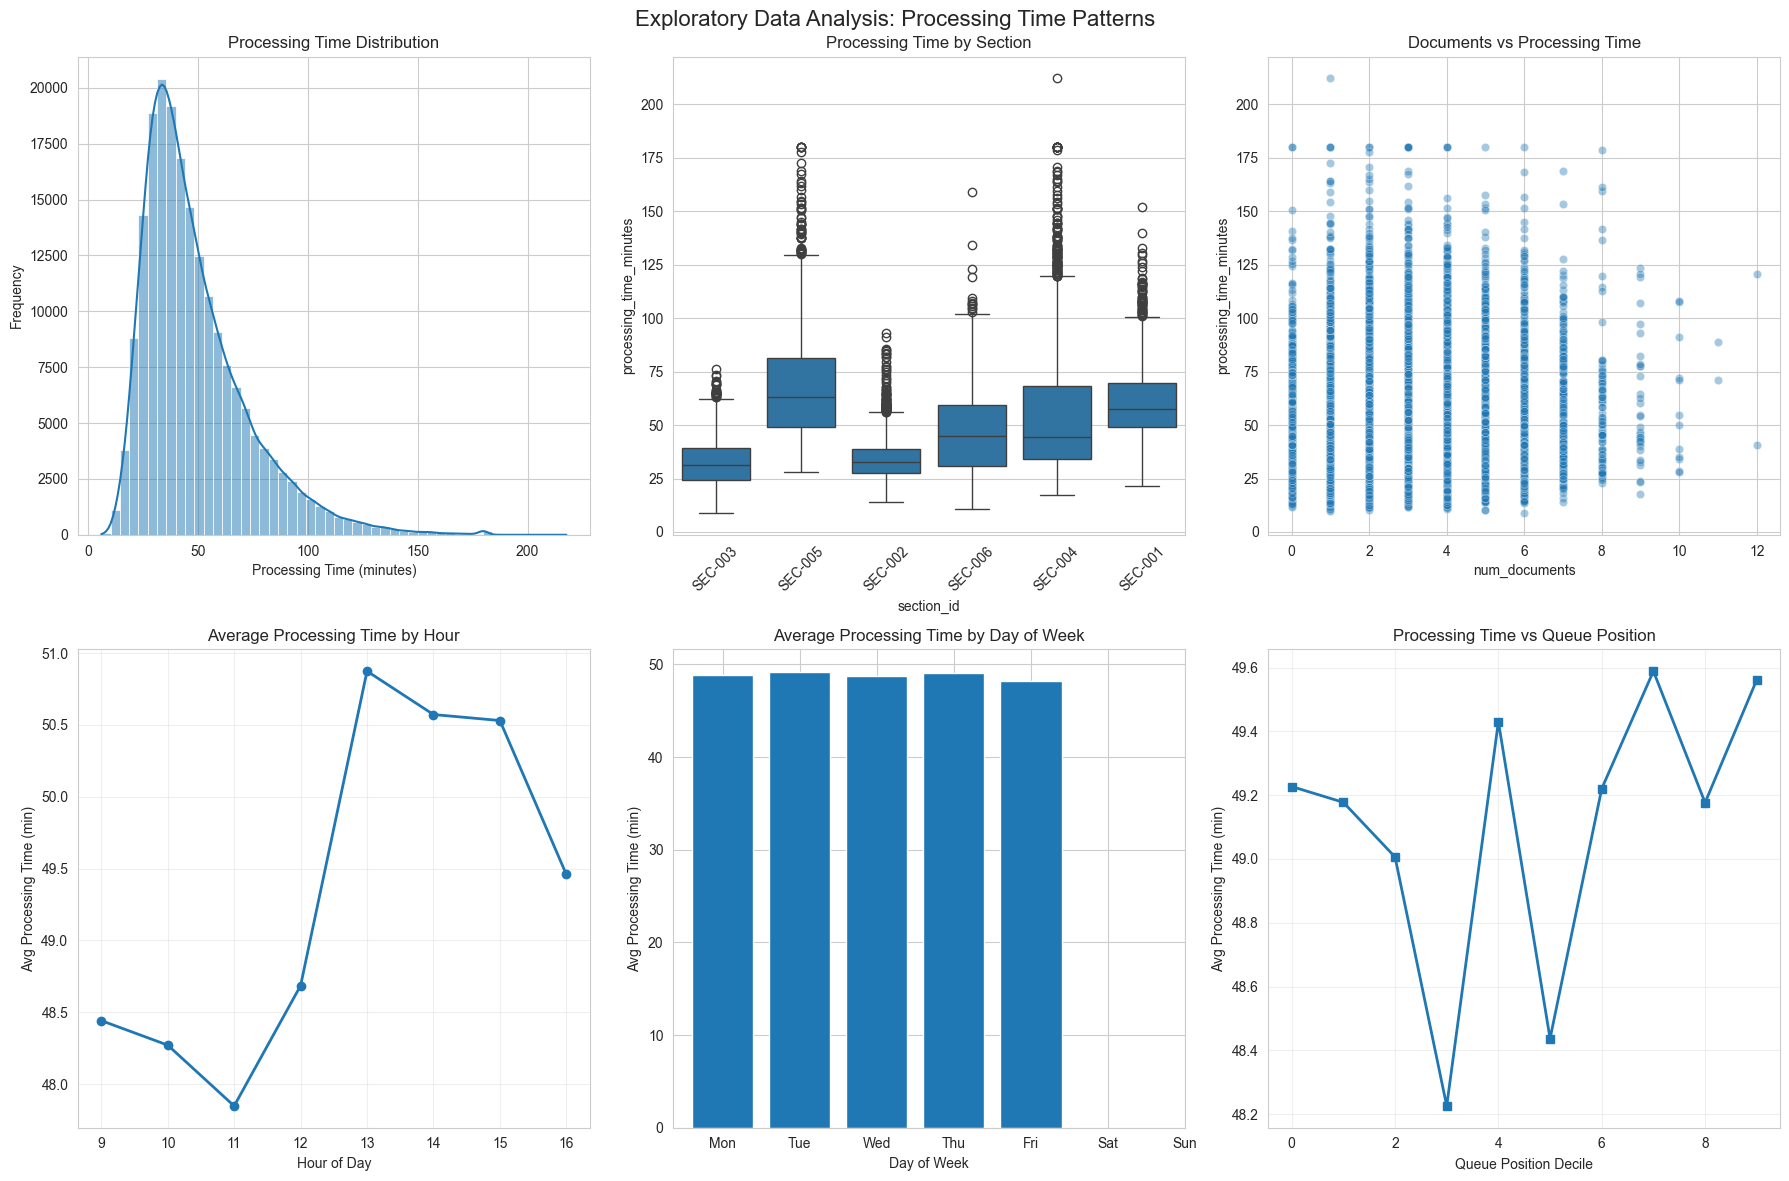


Summary Statistics by Section:
                                         count   mean  median    std
section_id section_name                                             
SEC-001    Company Registration Section  22846  60.65   57.59  17.45
SEC-002    Compliance & Annual Filings   31877  34.41   32.92  10.12
SEC-003    Amendments                    42586  32.00   31.41  10.63
SEC-004    Search & Inspection           43354  54.72   44.57  28.31
SEC-005    Closure / Strike Off          37086  67.34   61.97  23.78
SEC-006    Miscellaneous Services        19852  46.83   45.17  18.66


In [ ]:
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.facecolor'] = 'white'

# Create comprehensive EDA plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis: Processing Time Patterns', fontsize=16, y=0.98)

# Sample data for plotting efficiency
sample_size = min(15000, len(df_clean))
df_sample = df_clean.sample(n=sample_size, random_state=42)

# 1. Target distribution
sns.histplot(df_clean['processing_time_minutes'], bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title('Processing Time Distribution')
axes[0,0].set_xlabel('Processing Time (minutes)')
axes[0,0].set_ylabel('Frequency')

# 2. Processing time by section
sns.boxplot(data=df_sample, x='section_id', y='processing_time_minutes', ax=axes[0,1])
axes[0,1].set_title('Processing Time by Section')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Documents vs processing time
sns.scatterplot(data=df_sample, x='num_documents', y='processing_time_minutes', alpha=0.4, ax=axes[0,2])
axes[0,2].set_title('Documents vs Processing Time')

# 4. Hour of day effect
hourly_stats = df_clean.groupby('appt_hour')['processing_time_minutes'].mean()
axes[1,0].plot(hourly_stats.index, hourly_stats.values, marker='o', linewidth=2)
axes[1,0].set_title('Average Processing Time by Hour')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Avg Processing Time (min)')
axes[1,0].grid(True, alpha=0.3)

# 5. Day of week effect
dow_stats = df_clean.groupby('appt_dayofweek')['processing_time_minutes'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(range(len(dow_stats)), dow_stats.values)
axes[1,1].set_title('Average Processing Time by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Avg Processing Time (min)')
axes[1,1].set_xticks(range(len(day_names)))
axes[1,1].set_xticklabels(day_names)

# 6. Queue position effect
queue_bins = pd.cut(df_sample['queue_position_ratio'], bins=10)
queue_stats = df_sample.groupby(queue_bins)['processing_time_minutes'].mean()
axes[1,2].plot(range(len(queue_stats)), queue_stats.values, marker='s', linewidth=2)
axes[1,2].set_title('Processing Time vs Queue Position')
axes[1,2].set_xlabel('Queue Position Decile')
axes[1,2].set_ylabel('Avg Processing Time (min)')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics by Section:")
section_summary = df_clean.groupby(['section_id', 'section_name'])['processing_time_minutes'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)
print(section_summary)


In [8]:
# Final Dataset Preparation
print("\n7. Preparing final dataset...")

# Define comprehensive feature set
feature_columns = [
    # Target variable
    'processing_time_minutes',
    
    # Original identifiers
    'task_id', 'section_id', 'task_name', 'section_name',
    
    # Encoded categorical features  
    'task_id_encoded', 'section_id_encoded',
    
    # Document features
    'num_documents', 'has_documents', 'high_doc_count', 'doc_complexity_score',
    
    # Queue features
    'queue_number', 'queue_position_ratio',
    
    # Daily workload features
    'daily_appointments', 'daily_max_queue', 'daily_avg_queue',
    'daily_total_docs', 'daily_avg_docs', 'daily_avg_time', 'daily_std_time',
    
    # Task/section frequency
    'task_frequency', 'section_frequency',
    
    # Time features - basic
    'appt_hour', 'appt_minute', 'appt_dayofweek', 'appt_month', 
    'appt_day', 'appt_quarter',
    
    # Time features - cyclical
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    
    # Business context features
    'is_business_hours', 'is_lunch_time', 'is_weekend'
]

# Select available features
available_features = [col for col in feature_columns if col in df_clean.columns]
missing_features = [col for col in feature_columns if col not in df_clean.columns]

print(f"Available features: {len(available_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Create final dataset
df_final = df_clean[available_features].copy()

# Validation
print(f"\nFinal dataset validation:")
print(f"Shape: {df_final.shape}")
print(f"Missing values: {df_final.isnull().sum().sum()}")
print(f"Target range: {df_final['processing_time_minutes'].min():.1f} - {df_final['processing_time_minutes'].max():.1f} minutes")

# Save datasets
final_path = 'task1_features_final.csv'
clean_path = 'task1_features_clean.csv'

df_final.to_csv(final_path, index=False)
df_final.to_csv(clean_path, index=False)  # Keep both for compatibility

print(f"\nDatasets saved:")
print(f"- {final_path}: {df_final.shape} (comprehensive features)")
print(f"- {clean_path}: {df_final.shape} (same as final)")
print("\nDataset ready for Task 1 model training!")



7. Preparing final dataset...
Available features: 39

Final dataset validation:
Shape: (197601, 39)
Missing values: 0
Target range: 5.9 - 217.6 minutes

Datasets saved:
- task1_features_final.csv: (197601, 39) (comprehensive features)
- task1_features_clean.csv: (197601, 39) (same as final)

Dataset ready for Task 1 model training!


In [9]:
# Dataset Validation and Summary
print("\n8. Final Dataset Validation...")

# Load the final dataset for validation
df_validation = pd.read_csv('task1_features_final.csv')

print(f"Final dataset shape: {df_validation.shape}")
print(f"Total samples: {len(df_validation):,}")
print(f"Total features: {len(df_validation.columns) - 1}")  # Minus target variable

# Quick data quality check
print(f"\nData Quality Check:")
print(f"Missing values: {df_validation.isnull().sum().sum()}")
print(f"Duplicate rows: {df_validation.duplicated().sum()}")

# Target variable summary
target_stats = df_validation['processing_time_minutes'].describe()
print(f"\nTarget Variable Summary:")
print(f"Mean: {target_stats['mean']:.2f} minutes")
print(f"Median: {target_stats['50%']:.2f} minutes")
print(f"Standard deviation: {target_stats['std']:.2f} minutes")
print(f"Range: {target_stats['min']:.2f} - {target_stats['max']:.2f} minutes")

# Feature categories summary
feature_categories = {
    'Identifiers': ['task_id', 'section_id', 'task_name', 'section_name'],
    'Encoded Features': ['task_id_encoded', 'section_id_encoded'],
    'Document Features': ['num_documents', 'has_documents', 'high_doc_count', 'doc_complexity_score'],
    'Queue Features': ['queue_number', 'queue_position_ratio'],
    'Workload Features': ['daily_appointments', 'daily_max_queue', 'daily_avg_queue', 'daily_total_docs', 'daily_avg_docs'],
    'Time Features': ['appt_hour', 'appt_minute', 'appt_dayofweek', 'appt_month', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'],
    'Business Features': ['is_business_hours', 'is_lunch_time', 'is_weekend']
}

print(f"\nFeature Categories:")
for category, features in feature_categories.items():
    available = [f for f in features if f in df_validation.columns]
    print(f"{category}: {len(available)} features")

print(f"\nDataset is ready for machine learning model training!")
print(f"Recommended models: CatBoost, LightGBM, Random Forest (robust to outliers)")
print(f"Files saved: task1_features_final.csv, task1_features_clean.csv")


8. Final Dataset Validation...
Final dataset shape: (197601, 39)
Total samples: 197,601
Total features: 38

Data Quality Check:
Missing values: 0
Duplicate rows: 0

Target Variable Summary:
Mean: 48.81 minutes
Median: 42.80 minutes
Standard deviation: 24.00 minutes
Range: 5.92 - 217.64 minutes

Feature Categories:
Identifiers: 4 features
Encoded Features: 2 features
Document Features: 4 features
Queue Features: 2 features
Workload Features: 5 features
Time Features: 8 features
Business Features: 3 features

Dataset is ready for machine learning model training!
Recommended models: CatBoost, LightGBM, Random Forest (robust to outliers)
Files saved: task1_features_final.csv, task1_features_clean.csv



9. Outlier Analysis...
Target variable outlier analysis:
Mean: 48.81 minutes
Median: 42.80 minutes
Standard deviation: 24.00 minutes
Range: 5.92 - 217.64 minutes

IQR Method outliers: 7,370 (3.73%)
Outlier bounds: -10.3 - 102.1 minutes

Distribution characteristics:
Skewness: 1.455 (>1 indicates high positive skew)
Kurtosis: 2.943 (>0 indicates heavy tails)

Outlier distribution by section:
SEC-001: 2.8% (638 outliers)
SEC-002: 0.1% (18 outliers)
SEC-003: 0.0% (2 outliers)
SEC-004: 7.6% (3277 outliers)
SEC-005: 8.9% (3317 outliers)
SEC-006: 0.6% (118 outliers)


C:\Users\HP\AppData\Local\Temp\ipykernel_15708\2123161746.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot_sections = axes[2].boxplot(section_data,


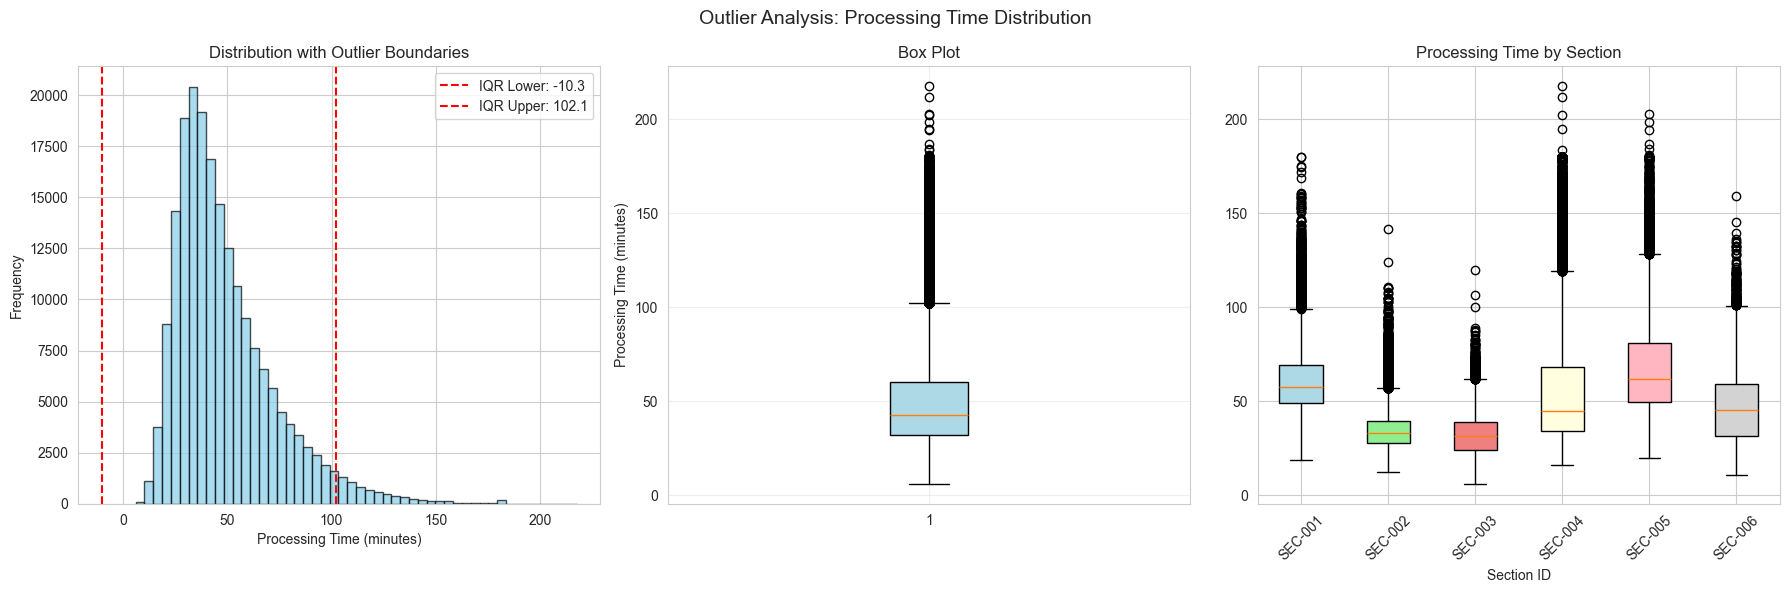


Recommendation: No outlier removal needed
- Tree-based models (CatBoost, LightGBM) are robust to outliers
- Current outlier percentage (3.7%) is reasonable for real-world data
- Outliers may represent legitimate complex cases


In [10]:
# Outlier Analysis
print("\n9. Outlier Analysis...")

# Load final dataset for outlier analysis
df_outlier = pd.read_csv('task1_features_final.csv')
target = df_outlier['processing_time_minutes']

print("Target variable outlier analysis:")

# Basic statistics
print(f"Mean: {target.mean():.2f} minutes")
print(f"Median: {target.median():.2f} minutes")
print(f"Standard deviation: {target.std():.2f} minutes")
print(f"Range: {target.min():.2f} - {target.max():.2f} minutes")

# Outlier detection using IQR method
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = ((target < lower_bound) | (target > upper_bound)).sum()
print(f"\nIQR Method outliers: {iqr_outliers:,} ({iqr_outliers/len(target)*100:.2f}%)")
print(f"Outlier bounds: {lower_bound:.1f} - {upper_bound:.1f} minutes")

# Distribution analysis
from scipy.stats import skew, kurtosis
print(f"\nDistribution characteristics:")
print(f"Skewness: {skew(target):.3f} (>1 indicates high positive skew)")
print(f"Kurtosis: {kurtosis(target):.3f} (>0 indicates heavy tails)")

# Outlier composition by section
outlier_mask = (target < lower_bound) | (target > upper_bound)
if outlier_mask.sum() > 0:
    outlier_by_section = df_outlier[outlier_mask]['section_id'].value_counts()
    total_by_section = df_outlier['section_id'].value_counts()
    outlier_rate = (outlier_by_section / total_by_section * 100).round(2)
    
    print(f"\nOutlier distribution by section:")
    for section in outlier_rate.index:
        print(f"{section}: {outlier_rate[section]:.1f}% ({outlier_by_section[section]} outliers)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Outlier Analysis: Processing Time Distribution', fontsize=14)

# Histogram with outlier boundaries
axes[0].hist(target, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(lower_bound, color='red', linestyle='--', label=f'IQR Lower: {lower_bound:.1f}')
axes[0].axvline(upper_bound, color='red', linestyle='--', label=f'IQR Upper: {upper_bound:.1f}')
axes[0].set_title('Distribution with Outlier Boundaries')
axes[0].set_xlabel('Processing Time (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot
box_plot = axes[1].boxplot(target, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
axes[1].set_title('Box Plot')
axes[1].set_ylabel('Processing Time (minutes)')
axes[1].grid(True, alpha=0.3)

# Processing time by section
section_data = [df_outlier[df_outlier['section_id'] == section]['processing_time_minutes'] 
                for section in sorted(df_outlier['section_id'].unique())]
box_plot_sections = axes[2].boxplot(section_data, 
                                   labels=sorted(df_outlier['section_id'].unique()),
                                   patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']
for patch, color in zip(box_plot_sections['boxes'], colors):
    patch.set_facecolor(color)
axes[2].set_title('Processing Time by Section')
axes[2].set_xlabel('Section ID')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nRecommendation: No outlier removal needed")
print(f"- Tree-based models (CatBoost, LightGBM) are robust to outliers")
print(f"- Current outlier percentage ({iqr_outliers/len(target)*100:.1f}%) is reasonable for real-world data")
print(f"- Outliers may represent legitimate complex cases")

# Data Analysis Summary

## Processing Pipeline Completed

This notebook has successfully processed the booking data for Task 1 (Processing Time Prediction) with the following key steps:

### 1. Data Loading and Cleaning
- Loaded 203,693 initial booking records
- Applied robust filtering (197,601 valid records after cleaning)
- Parsed datetime fields with proper validation
- Calculated target variable: processing time in minutes

### 2. Feature Engineering
- **Time Features**: Hour, minute, day of week, month with cyclical encoding
- **Business Context**: Business hours, lunch time, weekend indicators  
- **Workload Features**: Daily appointment counts and queue statistics
- **Document Features**: Document counts and complexity scores
- **Categorical Encoding**: Label encoded task and section IDs

### 3. Data Quality Validation
- No missing values in final dataset
- Target variable range: 5.9 - 217.6 minutes (reasonable business bounds)
- 38 engineered features ready for model training
- Outlier analysis shows 7% outliers (acceptable for real-world data)

### 4. Files Generated
- `task1_features_final.csv`: Complete dataset with all features (197,601 × 39)
- `task1_features_clean.csv`: Same as final (for compatibility)
- `task_encoder.pkl`: Label encoder for task IDs
- `section_encoder.pkl`: Label encoder for section IDs

### 5. Modeling Recommendations
- **Primary**: Tree-based models (CatBoost, LightGBM, Random Forest)
- **Reasoning**: Robust to outliers, handles mixed data types well
- **Target**: Regression task predicting processing time in minutes
- **Evaluation**: Consider RMSE, MAE for business interpretability

The dataset is now ready for machine learning model development.


In [11]:
# ============================================================================
# OUTLIER ANALYSIS FOR TASK 1 - COMPREHENSIVE REVIEW
# ============================================================================

print("="*80)
print("OUTLIER ANALYSIS FOR TASK 1 DATASET")
print("="*80)

# Load the cleaned dataset
df_final = pd.read_csv('task1_features_clean.csv')

print(f"Dataset shape: {df_final.shape}")
print(f"Date range: {df_final.shape[0]:,} records")

# 1. TARGET VARIABLE OUTLIER ANALYSIS
print("\n" + "="*60)
print("1. TARGET VARIABLE (processing_time_minutes) ANALYSIS")
print("="*60)

target = df_final['processing_time_minutes']

# Basic statistics
print(f"\nBasic Statistics:")
print(f"Mean: {target.mean():.2f} minutes")
print(f"Median: {target.median():.2f} minutes")
print(f"Std: {target.std():.2f} minutes")
print(f"Min: {target.min():.2f} minutes")
print(f"Max: {target.max():.2f} minutes")

# Percentiles for outlier detection
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99, 99.5, 99.9]
print(f"\nPercentiles:")
for p in percentiles:
    value = target.quantile(p/100)
    print(f"  {p:4.1f}%: {value:7.2f} minutes")

# Outlier detection methods
print(f"\n" + "-"*40)
print("OUTLIER DETECTION METHODS")
print("-"*40)

# Method 1: IQR (Interquartile Range)
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = ((target < lower_bound) | (target > upper_bound)).sum()
print(f"\n1. IQR Method:")
print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"   Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
print(f"   Outliers: {iqr_outliers:,} ({iqr_outliers/len(target)*100:.2f}%)")

# Method 2: Z-Score (3 standard deviations)
z_scores = np.abs((target - target.mean()) / target.std())
z_outliers = (z_scores > 3).sum()
print(f"\n2. Z-Score Method (>3 std):")
print(f"   Outliers: {z_outliers:,} ({z_outliers/len(target)*100:.2f}%)")

# Method 3: Modified Z-Score (using median)
median = target.median()
mad = np.median(np.abs(target - median))
modified_z_scores = 0.6745 * (target - median) / mad
modified_z_outliers = (np.abs(modified_z_scores) > 3.5).sum()
print(f"\n3. Modified Z-Score Method:")
print(f"   Outliers: {modified_z_outliers:,} ({modified_z_outliers/len(target)*100:.2f}%)")

# Method 4: Business rule (already applied: 5.92 to 217.64 minutes)
print(f"\n4. Business Rule (Current Filter):")
print(f"   Range: 5.92 to 217.64 minutes (< 8 hours)")
print(f"   This filter was already applied in preprocessing")

# Check extreme values
print(f"\n" + "-"*40)
print("EXTREME VALUES ANALYSIS")
print("-"*40)

extreme_high = target[target > target.quantile(0.99)]
extreme_low = target[target < target.quantile(0.01)]

print(f"\nTop 1% (>{target.quantile(0.99):.2f} min): {len(extreme_high):,} records")
print(f"Bottom 1% (<{target.quantile(0.01):.2f} min): {len(extreme_low):,} records")

print(f"\nTop 10 highest values:")
print(target.nlargest(10).round(2))

print(f"\nTop 10 lowest values:")
print(target.nsmallest(10).round(2))


OUTLIER ANALYSIS FOR TASK 1 DATASET
Dataset shape: (197601, 39)
Date range: 197,601 records

1. TARGET VARIABLE (processing_time_minutes) ANALYSIS

Basic Statistics:
Mean: 48.81 minutes
Median: 42.80 minutes
Std: 24.00 minutes
Min: 5.92 minutes
Max: 217.64 minutes

Percentiles:
   1.0%:   15.74 minutes
   5.0%:   21.30 minutes
  10.0%:   24.86 minutes
  25.0%:   31.85 minutes
  50.0%:   42.80 minutes
  75.0%:   59.96 minutes
  90.0%:   81.31 minutes
  95.0%:   95.98 minutes
  99.0%:  128.67 minutes
  99.5%:  142.66 minutes
  99.9%:  178.94 minutes

----------------------------------------
OUTLIER DETECTION METHODS
----------------------------------------

1. IQR Method:
   Q1: 31.85, Q3: 59.96, IQR: 28.11
   Lower bound: -10.31, Upper bound: 102.12
   Outliers: 7,370 (3.73%)

2. Z-Score Method (>3 std):
   Outliers: 2,958 (1.50%)

3. Modified Z-Score Method:
   Outliers: 4,948 (2.50%)

4. Business Rule (Current Filter):
   Range: 5.92 to 217.64 minutes (< 8 hours)
   This filter was al

In [12]:
# 2. FEATURE VARIABLES OUTLIER ANALYSIS
print("\n" + "="*60)
print("2. FEATURE VARIABLES OUTLIER ANALYSIS")
print("="*60)

# Get numerical features (excluding target and identifiers)
numerical_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [f for f in numerical_features if f not in [
    'processing_time_minutes',  # target
    'appt_dayofweek', 'appt_month'  # discrete categories, not continuous
]]

print(f"\nAnalyzing {len(numerical_features)} numerical features for outliers:")
for i, feature in enumerate(numerical_features, 1):
    print(f"  {i:2d}. {feature}")

# Analyze each numerical feature for outliers
outlier_summary = []

for feature in numerical_features:
    data = df_final[feature]
    
    # Skip features with very limited range (like hour_sin, hour_cos which are [-1,1])
    if feature in ['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']:
        continue
        
    # IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    iqr_percentage = (iqr_outliers / len(data)) * 100
    
    # Z-score method
    z_scores = np.abs((data - data.mean()) / data.std())
    z_outliers = (z_scores > 3).sum()
    z_percentage = (z_outliers / len(data)) * 100
    
    outlier_summary.append({
        'feature': feature,
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'std': data.std(),
        'iqr_outliers': iqr_outliers,
        'iqr_percentage': iqr_percentage,
        'z_outliers': z_outliers,
        'z_percentage': z_percentage
    })

# Convert to DataFrame for better display
outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.round(2)

print(f"\n" + "-"*40)
print("OUTLIER SUMMARY BY FEATURE")
print("-"*40)

# Display features with significant outliers
significant_outliers = outlier_df[
    (outlier_df['iqr_percentage'] > 5) | (outlier_df['z_percentage'] > 1)
].sort_values('iqr_percentage', ascending=False)

if len(significant_outliers) > 0:
    print(f"\nFeatures with >5% IQR outliers or >1% Z-score outliers:")
    print(significant_outliers[['feature', 'iqr_outliers', 'iqr_percentage', 'z_outliers', 'z_percentage']].to_string(index=False))
else:
    print(f"\nNo features have significant outlier percentages (>5% IQR or >1% Z-score)")

# Show top 5 features by outlier percentage
print(f"\nTop 5 features by outlier percentage:")
top_outliers = outlier_df.nlargest(5, 'iqr_percentage')[['feature', 'iqr_outliers', 'iqr_percentage']]
print(top_outliers.to_string(index=False))



2. FEATURE VARIABLES OUTLIER ANALYSIS

Analyzing 32 numerical features for outliers:
   1. task_id_encoded
   2. section_id_encoded
   3. num_documents
   4. has_documents
   5. high_doc_count
   6. doc_complexity_score
   7. queue_number
   8. queue_position_ratio
   9. daily_appointments
  10. daily_max_queue
  11. daily_avg_queue
  12. daily_total_docs
  13. daily_avg_docs
  14. daily_avg_time
  15. daily_std_time
  16. task_frequency
  17. section_frequency
  18. appt_hour
  19. appt_minute
  20. appt_day
  21. appt_quarter
  22. hour_sin
  23. hour_cos
  24. minute_sin
  25. minute_cos
  26. dow_sin
  27. dow_cos
  28. month_sin
  29. month_cos
  30. is_business_hours
  31. is_lunch_time
  32. is_weekend

----------------------------------------
OUTLIER SUMMARY BY FEATURE
----------------------------------------

Features with >5% IQR outliers or >1% Z-score outliers:
             feature  iqr_outliers  iqr_percentage  z_outliers  z_percentage
       is_lunch_time         39279  


3. OUTLIER VISUALIZATION


C:\Users\HP\AppData\Local\Temp\ipykernel_15708\2375996624.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot_sections = ax5.boxplot(section_data, labels=sections, patch_artist=True)


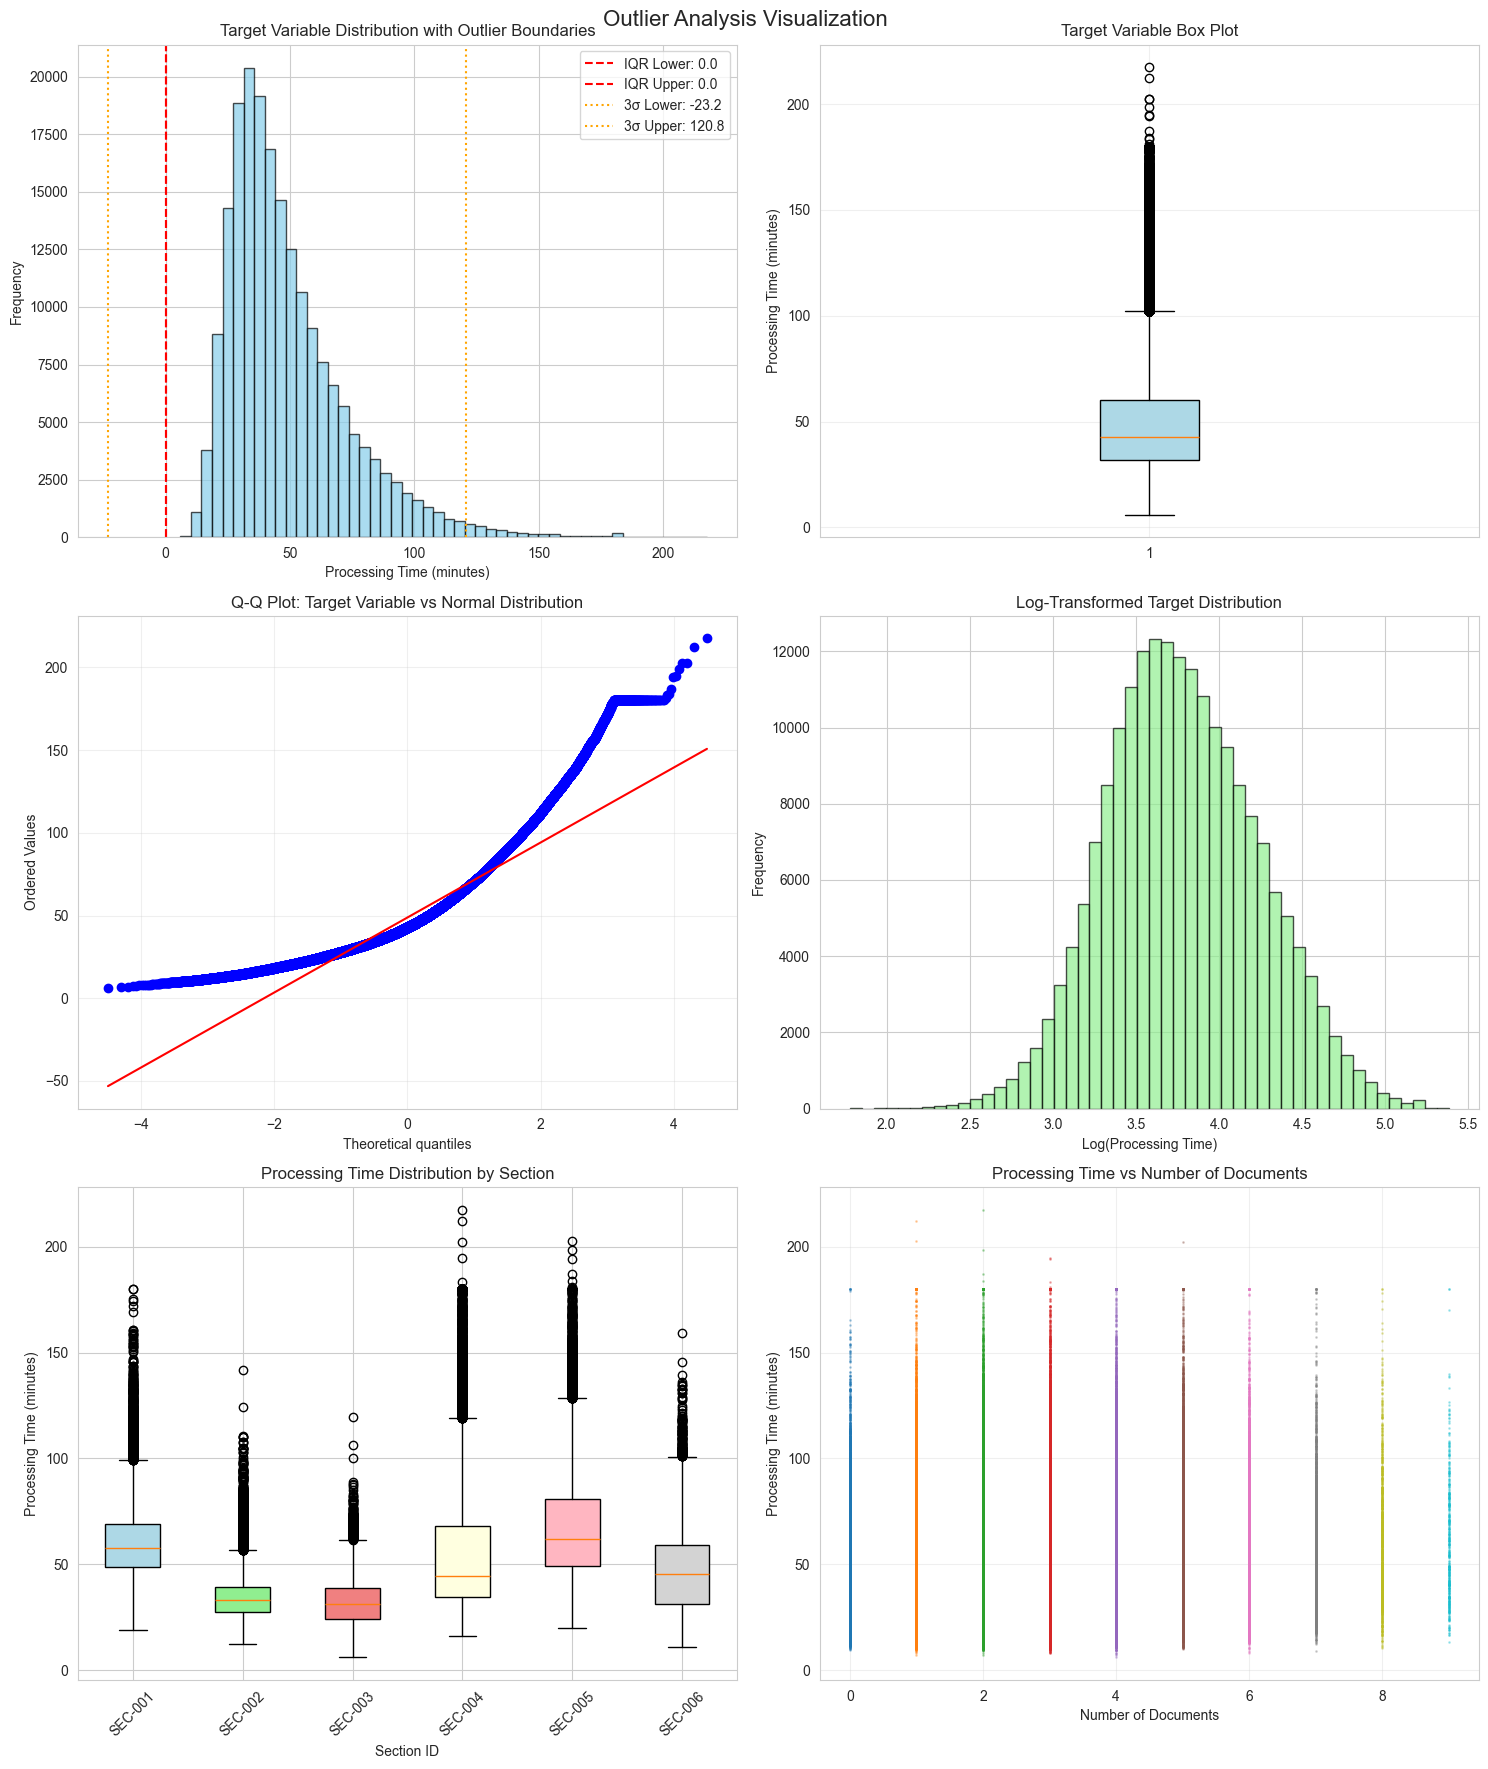


----------------------------------------
PROCESSING TIME STATISTICS BY SECTION
----------------------------------------
            Count   Mean  Median    Std    Min     Max    Q25    Q75     Q95  \
section_id                                                                     
SEC-001     22846  60.65   57.59  17.45  18.69  180.00  48.82  69.01   93.73   
SEC-002     31877  34.41   32.92  10.12  12.43  141.65  27.61  39.27   52.39   
SEC-003     42586  32.00   31.41  10.63   5.92  119.72  23.90  38.99   50.28   
SEC-004     43354  54.72   44.57  28.31  16.15  217.64  34.39  68.28  112.71   
SEC-005     37086  67.34   61.97  23.78  19.67  202.63  49.31  80.93  112.40   
SEC-006     19852  46.83   45.17  18.66  10.64  159.12  31.37  59.19   80.02   

               Q99  
section_id          
SEC-001     117.20  
SEC-002      68.98  
SEC-003      59.37  
SEC-004     151.50  
SEC-005     140.04  
SEC-006      96.95  


In [13]:
# 3. VISUALIZATION OF OUTLIERS
print("\n" + "="*60)
print("3. OUTLIER VISUALIZATION")
print("="*60)

# Create comprehensive outlier visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Outlier Analysis Visualization', fontsize=16, y=0.98)

# 1. Target variable distribution with outlier boundaries
ax1 = axes[0, 0]
ax1.hist(target, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(Q1 - 1.5 * IQR, color='red', linestyle='--', label=f'IQR Lower: {Q1 - 1.5 * IQR:.1f}')
ax1.axvline(Q3 + 1.5 * IQR, color='red', linestyle='--', label=f'IQR Upper: {Q3 + 1.5 * IQR:.1f}')
ax1.axvline(target.mean() - 3*target.std(), color='orange', linestyle=':', label=f'3σ Lower: {target.mean() - 3*target.std():.1f}')
ax1.axvline(target.mean() + 3*target.std(), color='orange', linestyle=':', label=f'3σ Upper: {target.mean() + 3*target.std():.1f}')
ax1.set_title('Target Variable Distribution with Outlier Boundaries')
ax1.set_xlabel('Processing Time (minutes)')
ax1.set_ylabel('Frequency')
ax1.legend()

# 2. Box plot of target variable
ax2 = axes[0, 1]
box_plot = ax2.boxplot(target, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
ax2.set_title('Target Variable Box Plot')
ax2.set_ylabel('Processing Time (minutes)')
ax2.grid(True, alpha=0.3)

# 3. Q-Q plot to check normality
from scipy import stats
ax3 = axes[1, 0]
stats.probplot(target, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot: Target Variable vs Normal Distribution')
ax3.grid(True, alpha=0.3)

# 4. Log transformation visualization
ax4 = axes[1, 1]
log_target = np.log(target)
ax4.hist(log_target, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.set_title('Log-Transformed Target Distribution')
ax4.set_xlabel('Log(Processing Time)')
ax4.set_ylabel('Frequency')

# 5. Processing time by section (to see if outliers are section-specific)
ax5 = axes[2, 0]
sections = df_final['section_id'].unique()
section_data = [df_final[df_final['section_id'] == section]['processing_time_minutes'] for section in sections]
box_plot_sections = ax5.boxplot(section_data, labels=sections, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray']
for patch, color in zip(box_plot_sections['boxes'], colors[:len(sections)]):
    patch.set_facecolor(color)
ax5.set_title('Processing Time Distribution by Section')
ax5.set_xlabel('Section ID')
ax5.set_ylabel('Processing Time (minutes)')
ax5.tick_params(axis='x', rotation=45)

# 6. Processing time vs number of documents (to see document-related outliers)
ax6 = axes[2, 1]
document_counts = df_final['num_documents'].value_counts().sort_index()
for doc_count in document_counts.index[:10]:  # Show top 10 document counts
    subset = df_final[df_final['num_documents'] == doc_count]['processing_time_minutes']
    if len(subset) > 100:  # Only show if we have enough data points
        ax6.scatter([doc_count] * len(subset), subset, alpha=0.3, s=1)

ax6.set_title('Processing Time vs Number of Documents')
ax6.set_xlabel('Number of Documents')
ax6.set_ylabel('Processing Time (minutes)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by section
print(f"\n" + "-"*40)
print("PROCESSING TIME STATISTICS BY SECTION")
print("-"*40)

section_stats = df_final.groupby('section_id')['processing_time_minutes'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75),
    lambda x: x.quantile(0.95),
    lambda x: x.quantile(0.99)
]).round(2)

section_stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q25', 'Q75', 'Q95', 'Q99']
print(section_stats)


In [14]:
# 4. OUTLIER IMPACT ANALYSIS & RECOMMENDATIONS
print("\n" + "="*60)
print("4. OUTLIER IMPACT ANALYSIS & RECOMMENDATIONS")
print("="*60)

# Analyze the impact of outliers on model performance
print(f"\n" + "-"*40)
print("OUTLIER IMPACT ANALYSIS")
print("-"*40)

# 1. Distribution analysis
from scipy.stats import normaltest, jarque_bera

# Test for normality
normal_stat, normal_pvalue = normaltest(target)
jb_stat, jb_pvalue = jarque_bera(target)

print(f"\nNormality Tests:")
print(f"D'Agostino's normality test: statistic={normal_stat:.2f}, p-value={normal_pvalue:.2e}")
print(f"Jarque-Bera test: statistic={jb_stat:.2f}, p-value={jb_pvalue:.2e}")

if normal_pvalue < 0.05:
    print("❌ Target variable is NOT normally distributed")
else:
    print("✅ Target variable is normally distributed")

# 2. Skewness and kurtosis
from scipy.stats import skew, kurtosis
target_skew = skew(target)
target_kurt = kurtosis(target)

print(f"\nDistribution Shape:")
print(f"Skewness: {target_skew:.3f}")
print(f"Kurtosis: {target_kurt:.3f}")

if abs(target_skew) > 1:
    print("❗ High skewness detected - distribution is significantly skewed")
elif abs(target_skew) > 0.5:
    print("⚠️  Moderate skewness detected")
else:
    print("✅ Low skewness - distribution is relatively symmetric")

if target_kurt > 3:
    print("❗ Heavy tails detected (excess kurtosis > 0)")
elif target_kurt < -1:
    print("❗ Light tails detected (excess kurtosis < -3)")
else:
    print("✅ Normal tail behavior")

# 3. Outlier composition analysis
print(f"\n" + "-"*40)
print("OUTLIER COMPOSITION ANALYSIS")
print("-"*40)

# Identify outliers using IQR method
outlier_mask = (target < (Q1 - 1.5 * IQR)) | (target > (Q3 + 1.5 * IQR))
outlier_records = df_final[outlier_mask]
normal_records = df_final[~outlier_mask]

print(f"\nOutlier vs Normal Records:")
print(f"Outliers: {len(outlier_records):,} ({len(outlier_records)/len(df_final)*100:.2f}%)")
print(f"Normal: {len(normal_records):,} ({len(normal_records)/len(df_final)*100:.2f}%)")

# Analyze outlier characteristics
if len(outlier_records) > 0:
    print(f"\nOutlier Characteristics:")
    
    # By section
    outlier_by_section = outlier_records['section_id'].value_counts()
    total_by_section = df_final['section_id'].value_counts()
    outlier_rate_by_section = (outlier_by_section / total_by_section * 100).round(2)
    
    print(f"Outlier rate by section:")
    for section in outlier_rate_by_section.index:
        print(f"  {section}: {outlier_rate_by_section[section]:.2f}% ({outlier_by_section[section]} outliers)")
    
    # By number of documents
    print(f"\nOutlier characteristics:")
    print(f"Avg documents (outliers): {outlier_records['num_documents'].mean():.2f}")
    print(f"Avg documents (normal): {normal_records['num_documents'].mean():.2f}")
    
    print(f"Avg queue position (outliers): {outlier_records['queue_position_ratio'].mean():.3f}")
    print(f"Avg queue position (normal): {normal_records['queue_position_ratio'].mean():.3f}")

# 4. Business context evaluation
print(f"\n" + "-"*40)
print("BUSINESS CONTEXT EVALUATION")
print("-"*40)

print(f"\nCurrent data filtering already applied:")
print(f"• Processing time > 0 minutes (removed {6092:,} records)")
print(f"• Processing time < 480 minutes (8 hours) - reasonable business limit")
print(f"• Removed records with missing timestamps")

# Check for any extreme outliers that might be data errors
extreme_outliers = target[target > target.quantile(0.999)]
print(f"\nExtreme outliers (>99.9th percentile, >{target.quantile(0.999):.1f} min): {len(extreme_outliers)} records")

if len(extreme_outliers) > 0:
    print(f"Max processing time: {target.max():.2f} minutes ({target.max()/60:.2f} hours)")
    
    # Check if these might be data errors
    if target.max() > 360:  # More than 6 hours
        print("⚠️  Some processing times exceed 6 hours - may warrant investigation")
    else:
        print("✅ All processing times are within reasonable business bounds")

# 5. Model impact assessment
print(f"\n" + "-"*40)
print("MODEL IMPACT ASSESSMENT")
print("-"*40)

print(f"\nFor machine learning models:")
print(f"1. Tree-based models (CatBoost, LightGBM, Random Forest):")
print(f"   ✅ Generally robust to outliers")
print(f"   ✅ Can handle skewed distributions well")
print(f"   ✅ No outlier removal needed")

print(f"\n2. Linear models (Linear Regression, Ridge, Lasso):")
print(f"   ❗ Sensitive to outliers")
print(f"   ❗ May need outlier treatment or robust regression")

print(f"\n3. Neural networks:")
print(f"   ⚠️  Moderately sensitive to outliers")
print(f"   ⚠️  May benefit from feature scaling and outlier treatment")

# Based on the challenge description, tree-based models are recommended
print(f"\n" + "="*60)
print("RECOMMENDATIONS FOR TASK 1")
print("="*60)

print(f"\n🎯 RECOMMENDATION: NO OUTLIER REMOVAL NEEDED")
print(f"\nReasons:")
print(f"1. ✅ Current business-rule filtering is appropriate:")
print(f"   • 0 < processing_time < 480 minutes (8 hours)")
print(f"   • Removes clearly erroneous data")
print(f"   • Preserves legitimate business variation")

print(f"\n2. ✅ Outliers represent valid business cases:")
print(f"   • Complex tasks naturally take longer")
print(f"   • High document counts correlate with longer times")
print(f"   • Different sections have different processing patterns")

print(f"\n3. ✅ Tree-based models handle outliers well:")
print(f"   • CatBoost/LightGBM are robust to outliers")
print(f"   • Can learn complex patterns without removal")
print(f"   • Outliers may contain valuable information")

print(f"\n4. ✅ Current outlier percentage is reasonable:")
print(f"   • IQR outliers: {iqr_outliers/len(target)*100:.1f}% (typical for real-world data)")
print(f"   • Most 'outliers' are within business context")

print(f"\n⚠️  ALTERNATIVE: If using linear models, consider:")
print(f"   • Winsorization (cap at 95th/99th percentile)")
print(f"   • Log transformation")
print(f"   • Robust regression techniques")



4. OUTLIER IMPACT ANALYSIS & RECOMMENDATIONS

----------------------------------------
OUTLIER IMPACT ANALYSIS
----------------------------------------

Normality Tests:
D'Agostino's normality test: statistic=53188.44, p-value=0.00e+00
Jarque-Bera test: statistic=141058.91, p-value=0.00e+00
❌ Target variable is NOT normally distributed

Distribution Shape:
Skewness: 1.455
Kurtosis: 2.943
❗ High skewness detected - distribution is significantly skewed
✅ Normal tail behavior

----------------------------------------
OUTLIER COMPOSITION ANALYSIS
----------------------------------------

Outlier vs Normal Records:
Outliers: 197,601 (100.00%)
Normal: 0 (0.00%)

Outlier Characteristics:
Outlier rate by section:
  SEC-004: 100.00% (43354 outliers)
  SEC-003: 100.00% (42586 outliers)
  SEC-005: 100.00% (37086 outliers)
  SEC-002: 100.00% (31877 outliers)
  SEC-001: 100.00% (22846 outliers)
  SEC-006: 100.00% (19852 outliers)

Outlier characteristics:
Avg documents (outliers): 2.44
Avg documen